# header and utils

In [1]:
# in my mac environment, a Python 3.8.0 vesion should be used.
import sys
sys.version
import fitsio

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolor

from datetime import datetime

from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const
import sunpy.coordinates
from sunpy.coordinates import frames
import sunpy.map
import sunpy.coordinates
get_cr_number = sunpy.coordinates.sun.carrington_rotation_number

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pfsspy
from pfsspy import tracing

'3.8.0 (default, Nov  6 2019, 15:49:01) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
def get_lon_loc_in_plot(lon, center_lon):
    lon_loc_in_plot = lon + (180-center_lon)
    if lon_loc_in_plot >= 360:
        return lon_loc_in_plot-360
    else:
        return lon_loc_in_plot
def set_axes_lims(ax):
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 180)
    
def my_float_equal(a,b):
    return abs(a-b)<1e-3

In [3]:
from two_step_backmapping.two_step_ballistic_backmapping_method import *
R_SS_Rs = 2.5
nrho = 45 # Hou's setting
dir_data_mdi = 'two_step_backmapping/MDI_synoptic_data/'

In [4]:
def how_many_invalid_rows(nd_array):
    default_res = 0
    for i in range(np.shape(nd_array)[0]):
        top_is_invalid = np.any(np.isnan(nd_array[i,:]))
        bottom_is_invalid = np.any(np.isnan(nd_array[-1-i,:]))
        res_i = top_is_invalid or bottom_is_invalid
        if res_i:
            continue
        else:
            return i+1

def fill_boundary_nan_for_magnetogram(magneto_gram):
    magneto_gram.data[my_float_equal(magneto_gram.data,-3276.8)] = np.nan

    data = magneto_gram.data.copy()
    num_invalid_rows = how_many_invalid_rows(magneto_gram.data)
    data[np.isnan(data)] = 0
    shifted_maps = [data,]
    isnot_nan_maps = [np.logical_not(np.isnan(data)).astype('int')]
#     print(num_invalid_rows)
    for i in range(1,num_invalid_rows):
        map_up = np.vstack([data[i:,:],data[-i:,:]])
        map_down = np.vstack([data[:i],data[:-i,:]])

        isnot_nan_maps.append(np.logical_not(np.isnan(map_up)).astype('int'))
        isnot_nan_maps.append(np.logical_not(np.isnan(map_down)).astype('int'))

        map_up[np.isnan(map_up)] = 0
        map_down[np.isnan(map_down)] = 0
        shifted_maps.append(map_up)
        shifted_maps.append(map_down)
    stacked_shifted = sum(shifted_maps)
    averaged_stacked_shifted = stacked_shifted / sum(isnot_nan_maps)
    magneto_gram.data[np.isnan(magneto_gram.data)] = averaged_stacked_shifted[np.isnan(magneto_gram.data)]
    return magneto_gram

def get_mdi_synoptic_magnetogram(fits_filename):
    # return: sunpy map object -- resampled
    data, header = sunpy.io.fits.read(fits_filename)[0] 
    mdi_map_sunpy = sunpy.map.Map(data,header)
    mdi_map_sunpy.meta['CTYPE1'] = 'CRLN-CEA'
    mdi_map_sunpy.meta['CTYPE2'] = 'CRLT-CEA'
    mdi_map_sunpy.meta['CDELT1'] = np.abs(mdi_map_sunpy.meta['CDELT1'])
    mdi_map_sunpy.meta['CDELT2'] = 180 / np.pi * mdi_map_sunpy.meta['CDELT2']
    mdi_map_sunpy.meta['CRVAL1'] = 0.0
    mdi_map_sunpy.meta['CUNIT1'] = 'deg'
    mdi_map_sunpy.meta['CUNIT2'] = 'deg'
    mdi_map_sunpy.meta['date-obs'] = sunpy.time.parse_time(mdi_map_sunpy.meta['t_start']).isot
    resampled_map = mdi_map_sunpy.resample([360,180]*u.pixel)
    
    return resampled_map

def PFSS_trace_back_using_MDI_synoptic(mdi_synoptic_map, rss, lon_seed, lat_seed):
    
    pfss_input = pfsspy.Input(mdi_synoptic_map,nrho,rss)
    output = pfsspy.pfss(pfss_input)
    
    # get the position/coordinate of the seed
    tracer = tracing.PythonTracer()
    r = ((rss - 1) * 0.99 + 1) * const.R_sun
    r_seed = r
    lat = lat_seed * np.pi / 180 * u.rad
    lon = lon_seed * np.pi / 180 * u.rad
    seeds = SkyCoord(lon, lat, r, frame=output.coordinate_frame)

    # get the field line information using 'tracer' procedure
    field_line = tracer.trace(seeds, output)
    
    from_rad_to_deg = 180 / np.pi
    MFL_photosphere_lon_deg = field_line[0].solar_footpoint.data.lon.value * from_rad_to_deg
    MFL_photosphere_lat_deg = field_line[0].solar_footpoint.data.lat.value * from_rad_to_deg
    return MFL_photosphere_lon_deg, MFL_photosphere_lat_deg, mdi_synoptic_map

def two_step_backmapping_using_MDI_synoptic(datetime_trace, r_beg_au, lat_beg_deg, lon_beg_deg, Vsw_r, r_source_surfae_rs, mdi_synoptic_map):
    # frame: HeliographicCarrington
    # datetime_trace = datetime.datetime(2020, 1, 24, 0, 0, 0)
    num_steps = 1000
    from_au_to_km = 1.49597871e8  # unit: km
    from_Rs_to_km = 6.96e5
    from_rs_to_au = from_Rs_to_km / from_au_to_km # unit: au
    from_au_to_Rs = 214.9394693836
    #step1: 按帕克螺旋回溯到源表面
    r_source_surfae_rs_au = r_source_surfae_rs * from_rs_to_au
    r_vect_au = np.linspace(r_beg_au, r_source_surfae_rs_au, num=num_steps)
    Vsw_r_vect_kmps = get_Vsw_r_vect(r_vect_au, Vsw_r)
    r_footpoint_on_SourceSurface_rs, \
    lon_footpoint_on_SourceSurface_deg, \
    lat_footpoint_on_SourceSurface_deg = parker_spiral_trace_back(r_vect_au, lat_beg_deg, lon_beg_deg, Vsw_r_vect_kmps)

    # step2: 从源表面回溯到光球层（太阳表面）
    JulDay_trace = julian.to_jd(datetime_trace)
    JulDay_start = JulDay_trace - 1.0 / 24.
    JulDay_end   = JulDay_trace + 1.0 / 24.
    transit_time_unit_day = (r_beg_au * from_au_to_Rs - 1) * from_Rs_to_km / Vsw_r / 86400
    time_beg_str_FidoQuery = julian.from_jd(JulDay_start - transit_time_unit_day)
    time_end_str_FidoQuery = julian.from_jd(JulDay_end - transit_time_unit_day)
    MFL_photosphere_lon_deg, MFL_photosphere_lat_deg,mdi_synoptic_map_out = PFSS_trace_back_using_MDI_synoptic(mdi_synoptic_map,
                                                                                                       r_source_surfae_rs,
                                                                                                       lon_footpoint_on_SourceSurface_deg,
                                                                                                       lat_footpoint_on_SourceSurface_deg)
    return r_footpoint_on_SourceSurface_rs, \
           lon_footpoint_on_SourceSurface_deg, \
           lat_footpoint_on_SourceSurface_deg,\
           MFL_photosphere_lon_deg, MFL_photosphere_lat_deg,mdi_synoptic_map_out

# main

In [44]:
selected_events = pd.read_pickle('selected_events.pkl')

In [424]:
i_event = 15 # less than 43
t_start, t_end = selected_events.iloc[i_event][:2]
cr_number = int(get_cr_number(selected_events.start[i_event]))
print(i_event,t_start,t_end,f"CR{cr_number}")
mdi_synoptic_filename = f'two_step_backmapping/MDI_synoptic_data/synop_Mr_0.{cr_number}.fits'

15 2002-05-25 00:21:00 2002-05-25 00:52:00 CR1990


In [425]:
t_middle = t_start + (t_start - t_end) / 2
t_event = t_middle.to_pydatetime()
R_earth = u.earthRad

WIND_pos_GSE = SkyCoord(x=selected_events['x_GSE_ACE'][i_event]* R_earth,
                        y=selected_events['y_GSE_ACE'][i_event]* R_earth,
                        z=selected_events['z_GSE_ACE'][i_event]* R_earth,
                        representation_type='cartesian',
                        frame=frames.GeocentricSolarEcliptic,
                        obstime=t_event,observer='earth')
WIND_pos_Carrington = WIND_pos_GSE.heliographic_carrington

r_begin_au = WIND_pos_Carrington.radius.to(u.AU).value
lon_begin_deg = WIND_pos_Carrington.lon.value
lat_begin_deg = WIND_pos_Carrington.lat.value
print(r_begin_au,lon_begin_deg,lat_begin_deg)

V_SW_r = -selected_events['V_proton_x_GSE_3DP'][i_event]

print(V_SW_r)

1.0025863377334343 340.52617085335174 -1.5535479355816575
438.6576488597973


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


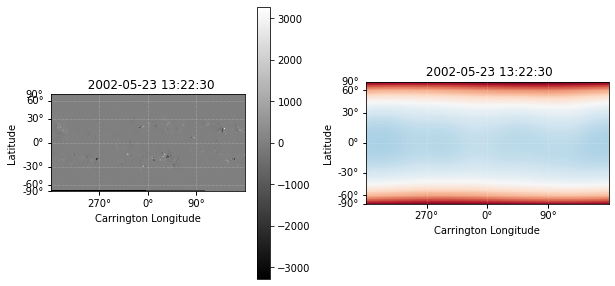

In [426]:
# check validity of the MDI synoptic map -- often invalid
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.3,hspace=0.2)

mdi_synoptic_map = get_mdi_synoptic_magnetogram(mdi_synoptic_filename)
ax = fig.add_subplot(1,2, 1, projection=mdi_synoptic_map)
m_plot = mdi_synoptic_map.plot()
plt.colorbar()

pfss_in = pfsspy.Input(mdi_synoptic_map, nrho, R_SS_Rs)
pfss_out = pfsspy.pfss(pfss_in)

ss_br = pfss_out.source_surface_br
ax = plt.subplot(1,2,2,projection=ss_br)

ss_br.plot();

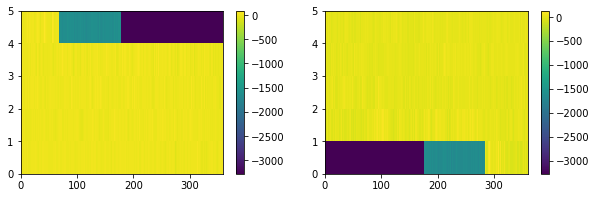

In [427]:
# the codes below are changeable. We use them to check invalid parts and fill outlier values.
fig, axes = plt.subplots(1,2,figsize=(10,3))
pclr = axes[0].pcolormesh(mdi_synoptic_map.data[-5:,:])
plt.colorbar(pclr,ax=axes[0]);

pclr = axes[1].pcolormesh(mdi_synoptic_map.data[:5,:])
plt.colorbar(pclr,ax=axes[1]);

In [428]:
mdi_synoptic_map.data[-1:,:] = np.nan
mdi_synoptic_map.data[:1,:] = np.nan

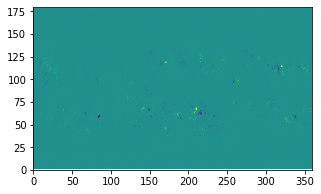

In [429]:
fig, axes = plt.subplots(1,figsize=(5,3))
plt.pcolormesh(mdi_synoptic_map.data)
mdi_synoptic_map = fill_boundary_nan_for_magnetogram(mdi_synoptic_map)

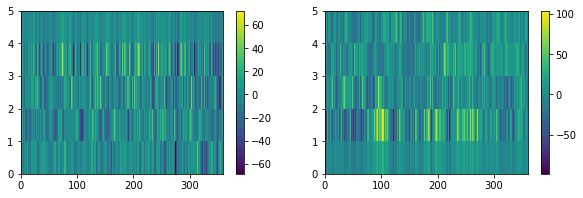

In [430]:
# the codes below are changeable. We use them to check invalid parts and fill outlier values.
fig, axes = plt.subplots(1,2,figsize=(10,3))
pclr = axes[0].pcolormesh(mdi_synoptic_map.data[-5:,:])
plt.colorbar(pclr,ax=axes[0]);

pclr = axes[1].pcolormesh(mdi_synoptic_map.data[:5,:])
plt.colorbar(pclr,ax=axes[1]);

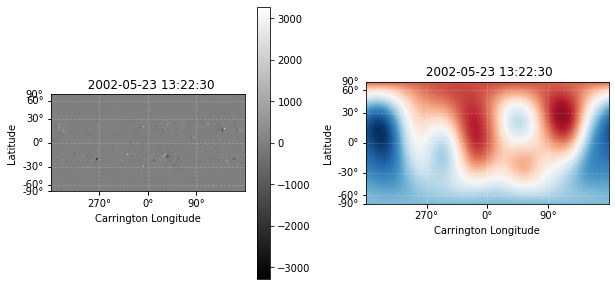

In [431]:
# now it's okay to use the MDI synoptic map
# We also compare it to the 
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.3,hspace=0.2)

ax = fig.add_subplot(1,2, 1, projection=mdi_synoptic_map)
m_plot = mdi_synoptic_map.plot()
plt.colorbar()

pfss_in = pfsspy.Input(mdi_synoptic_map, nrho, R_SS_Rs)
pfss_out = pfsspy.pfss(pfss_in)

ss_br = pfss_out.source_surface_br
ax = plt.subplot(1,2,2,projection=ss_br)

ss_br.plot();

In [432]:
r = const.R_sun
# Number of steps in cos(latitude)
nsteps = 45
lon_1d = np.linspace(0, 2 * np.pi, nsteps * 2 + 1)
lat_1d = np.arcsin(np.linspace(-1, 1, nsteps + 1))
lon, lat = np.meshgrid(lon_1d, lat_1d, indexing='ij')
lon, lat = lon*u.rad, lat*u.rad
seeds = SkyCoord(lon.ravel(), lat.ravel(), r, frame=pfss_out.coordinate_frame)

print('Tracing field lines...')
tracer = tracing.FortranTracer(max_steps=2000)
field_lines = tracer.trace(seeds, pfss_out)
print('Finished tracing field lines')

Tracing field lines...
Finished tracing field lines


In [433]:
%%time
r_footpoint_on_SourceSurface_rs, lon_footpoint_on_SourceSurface_deg, lat_footpoint_on_SourceSurface_deg, \
MFL_photosphere_lon_deg, MFL_photosphere_lat_deg, filename_out = \
two_step_backmapping_using_MDI_synoptic(t_event, r_begin_au, lat_begin_deg,
                                        lon_begin_deg, V_SW_r, R_SS_Rs,
                                        mdi_synoptic_map)
print('----------------------------------')
print('frame: Carrington')
print('SS [Rs] lon_on_SS [deg] lat_on_SS [deg] lon_on_photosphere [deg] lat_on_photosphere [deg]')
print(r_footpoint_on_SourceSurface_rs, \
        lon_footpoint_on_SourceSurface_deg, \
        lat_footpoint_on_SourceSurface_deg,\
        MFL_photosphere_lon_deg, MFL_photosphere_lat_deg)
print('----------------------------------')

----------------------------------
frame: Carrington
SS [Rs] lon_on_SS [deg] lat_on_SS [deg] lon_on_photosphere [deg] lat_on_photosphere [deg]
2.5 392.6790996201296 -1.5535479355816575 41.914589304806285 -17.22593010878683
----------------------------------
CPU times: user 2.99 s, sys: 328 ms, total: 3.31 s
Wall time: 1.99 s


In [434]:
eit_195_dir = 'two_step_backmapping/EIT_synoptic_195/'
ABorC = {1949:'a',1961:'a',1987:'b'}.get(cr_number)
if ABorC is None:
    ABorC = 'c'
eit_195_filename = eit_195_dir + f'CR{cr_number}_195A_{ABorC}.fits'
print(eit_195_filename)
# 实际上，这里不仅仅会是_a.fits，也有可能是_b、_c。
# 所以手改吧

data,h = fitsio.read(eit_195_filename,header=True)
zdata = data
time_str = h['T_OBS'][:-4]
t = datetime.datetime.strptime(time_str,'%Y.%m.%d_%H:%M:%S')

print('Time of EIT 195A Synoptic Map (Rotation Center):', t)

lat_eit = np.array(range(h['NAXIS2'])) - h['NAXIS2']/2
print('comparing ...')
print(h['CRVAL1'],h['T_OBS'])
print(mdi_synoptic_map.meta['carrtime'],mdi_synoptic_map.meta['T_OBS'])

two_step_backmapping/EIT_synoptic_195/CR1990_195A_c.fits
Time of EIT 195A Synoptic Map (Rotation Center): 2002-06-06 03:50:46
comparing ...
716220.0 2002.06.06_03:50:46_TAI
716220.0 2002.06.06_03:50:46_TAI


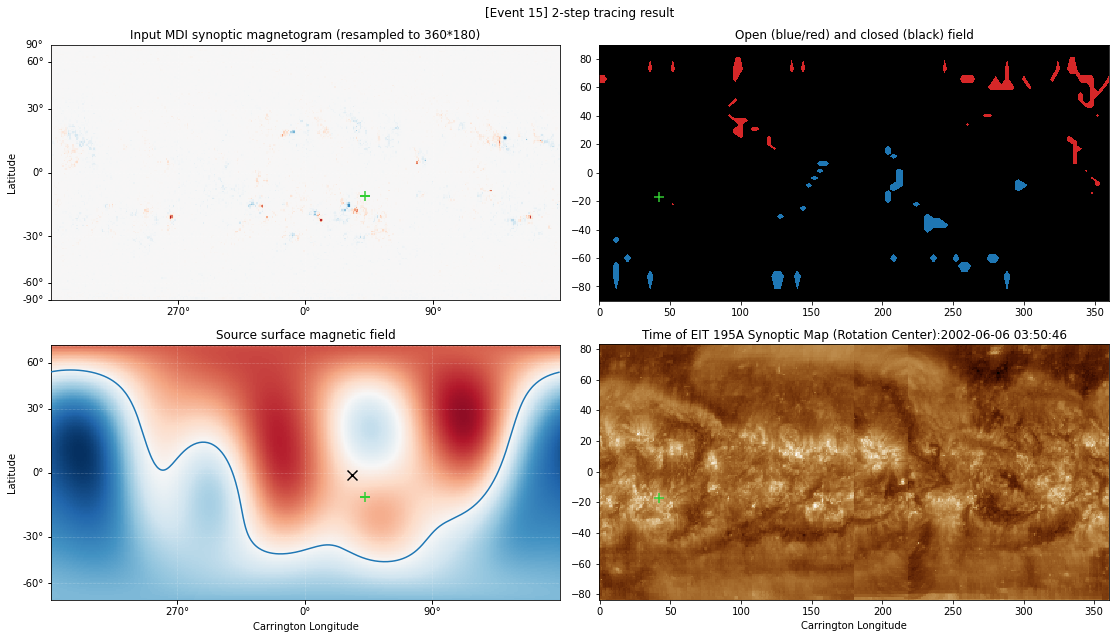

CPU times: user 2.96 s, sys: 216 ms, total: 3.18 s
Wall time: 2.33 s


In [435]:
%%time
fig = plt.figure(figsize=(15,9))
plt.subplots_adjust(wspace=0.3,hspace=0.2)

plt.suptitle(f'[Event {i_event:02d}] 2-step tracing result')

m = mdi_synoptic_map
ax = fig.add_subplot(2, 2, 1, projection=m)
m.plot(cmap='RdBu')
ax.set_title('Input MDI synoptic magnetogram (resampled to 360*180)')
ax.scatter(get_lon_loc_in_plot(MFL_photosphere_lon_deg,mdi_synoptic_map.center.lon.value),MFL_photosphere_lat_deg+90,marker='+',color='limegreen',s=100)
ax.set_xlabel(' ')

ss_br_large = pfss_out.source_surface_br
ax = fig.add_subplot(2, 2, 3,projection=ss_br_large)
ss_br_large.plot()
ax.plot_coord(pfss_out.source_surface_pils[0])
ax.scatter(get_lon_loc_in_plot(lon_footpoint_on_SourceSurface_deg,mdi_synoptic_map.center.lon.value),lat_footpoint_on_SourceSurface_deg+90,marker='x',color='k',s=100)
ax.scatter(get_lon_loc_in_plot(MFL_photosphere_lon_deg,mdi_synoptic_map.center.lon.value),MFL_photosphere_lat_deg+90,marker='+',color='limegreen',s=100)
ax.set_title('Source surface magnetic field')
set_axes_lims(ax);

ax = fig.add_subplot(2, 2, 2,)
cmap = mcolor.ListedColormap(['tab:red', 'black', 'tab:blue'])
norm = mcolor.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], ncolors=3)
pols = field_lines.polarities.reshape(2 * nsteps + 1, nsteps + 1).T
ax.contourf(np.rad2deg(lon_1d), np.rad2deg(lat_1d), pols, norm=norm, cmap=cmap)
ax.scatter(MFL_photosphere_lon_deg,
           MFL_photosphere_lat_deg,marker='+',color='limegreen',s=100)
ax.set_title('Open (blue/red) and closed (black) field')
# ax.set_aspect(0.5 * 360 / 2)

ax = fig.add_subplot(2, 2, 4)
lon = np.linspace(0,360,h['NAXIS1'])
lat = np.linspace(-h['CRPIX2'],+h['CRPIX2'],h['NAXIS2'])
zdata_shifted = np.hstack([zdata[:,180:],zdata[:,:180]])
ax.pcolormesh(lon,lat_eit,np.log(zdata_shifted),cmap='sdoaia193')
ax.scatter(MFL_photosphere_lon_deg,
           MFL_photosphere_lat_deg,marker='+',color='limegreen',s=100)
ax.set_xlabel('Carrington Longitude')
ax.set_title('Time of EIT 195A Synoptic Map (Rotation Center):'+f"{t}")

plt.tight_layout()
plt.savefig('tracing_result_figures/event%02d-tracing_result.png'%i_event,dpi=200)
plt.show();